#Image of Brain Stroke Lesion Segementation classified with X-Net and Quaternion Nerual Network


---


@Authors:
*   Alessandro Lambertini
*   Denise Landini




##Import libraries

In [ ]:
import os
from os import listdir
from os.path import isfile, join, isdir

from google.colab import drive
import tensorflow as tf
import pickle
import numpy as np
from numpy import asarray

import keras
from keras import backend, callbacks, regularizers, optimizers
from keras.layers import Input, Flatten, Dropout, Dense, Activation, Conv2D, MaxPooling2D,AveragePooling2D, UpSampling2D,\
    BatchNormalization, DepthwiseConv2D, add, dot, Reshape, Concatenate,\
    GlobalMaxPooling2D, Conv2DTranspose, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.models import load_model, Sequential

from imageio import imread

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

from skimage.transform import resize
from PIL import Image
import random
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import time

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Definition of some useful functions and class

In [ ]:
dir = '/content/drive/My Drive/Colab Notebooks/NN/Patients/'
dir_M = '/content/drive/My Drive/Colab Notebooks/NN/Model/'
dir_H = '/content/drive/My Drive/Colab Notebooks/NN/History/'

In [ ]:
def saveWeights(model, problem):
  filename = os.path.join(dir_M, problem)
  model.save_weights(filename)
  print("\nModel weights saved on file %s" %filename)

def saveHistory(history, problem):
  filename = os.path.join(dir_H, '%s.hist' %problem)
  with open(filename, 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)
  print("\nHystory saved on file %s" %filename)

def loadWeights(problem):
  filename = os.path.join(dir_M, problem)
  try:
    model = X_Net_model()
    model.load_weights(filename)#.expect_partial()
    print("\nModel weights loaded successfully from file %s" %filename)
  except OSError:    
    print("\nModel weights file %s not found!!!" %filename)
    model = None
  return model

def loadHistory(problem):
  filename = os.path.join(dir_H, '%s.hist' %problem)
  try:
    with open(filename, 'rb') as f:
      history = pickle.load(f)
      print("\nHistory loaded successfully from file %s" %filename)
  except OSError:    
    print("\nHistory file %s not found!!!" %filename)
    history = None
  return history

def plt_data_from_history(history, name, data):
  assert data in history.keys()

  plt.plot(history[data])
  plt.plot(history['val_' + data])
  plt.title(name + ' ' + data)
  plt.ylabel(data)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def progress(value, max=100):
  return HTML("""
    <progress
      value='{value}'
      max='{max}',
      style='width: 50%'
    >
        {value}
    </progress>
  """.format(value=value, max=max))

##Preprocessing of the data

In [ ]:
input_shape = (224, 192)
l_pat = listdir(dir)
l_pat.sort()

images_i = []
images_o = []

out = display(progress(0, len(l_pat)-1), display_id=True)
print("Image input: %s" %str(input_shape))
print("Patients in the dataset:")

num_pat = 0

for j in range(len(l_pat)):
  patient = l_pat[j]
  num_pat += 1
  
  if not isdir(dir+patient):
    continue
  
  path = dir+patient+'/brain/'
  l = sorted(listdir(path))
  l = sorted(l, key = lambda x: int(x[0]) if len(x) < 6 or (len(x) < 14 and x.count("_HGE_Seg")==1) else int(x[:2]) )

  i = 0
  dim = len(l)
  app_i = []
  app_o = []

  while i < dim:
    app_i.append(imread(path+l[i], as_gray=True))
    if i+1 < dim and l[i+1].count("_HGE_Seg")==1:
      i+=1
      app_o.append(imread(path+l[i], as_gray=True))
    else:
      app_o.append(imread(dir_M+"black.jpg", as_gray=True))
    i+=1
  
  images_i.append(app_i)
  images_o.append(app_o)
  out.update(progress(j, len(l_pat)-1))

print(num_pat)

Image input: (224, 192)
Patients in the dataset:
82


###Resize of the images

In [ ]:
for i in range(len(images_i)):
  for j in range(len(images_i[i])):
    images_i[i][j] = resize(images_i[i][j], input_shape)

for i in range(len(images_o)):
  for j in range(len(images_o[i])):
    images_o[i][j] = resize(images_o[i][j], input_shape)

###Generate a random image input and the respective output

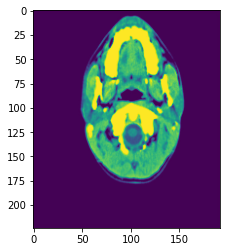

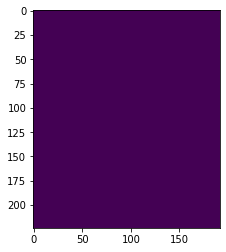

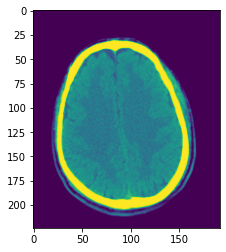

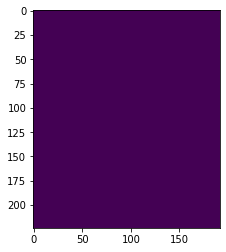

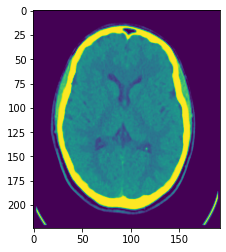

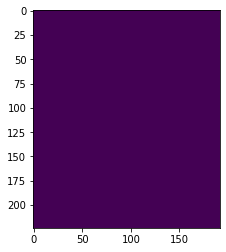

In [ ]:
N = 3

for _ in range(N):
  i = random.randint(0, len(images_i)-1)
  k = random.randint(0, len(images_i[i])-1)

  a = images_i[i][k]
  plt.imshow(a)
  plt.show()

  b = images_o[i][k]
  plt.imshow(b)
  plt.show()

##Split data

In [ ]:
x_all = np.array( [ np.array([images_i[i][j] for j in range(len(images_i[i]))] ) for i in range(len(images_i))] , dtype=object)
y_all = np.array( [ np.array([images_o[i][j] for j in range(len(images_o[i]))] ) for i in range(len(images_o))] , dtype=object)
print(x_all.shape)
print(y_all.shape)

(82,)
(82,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images_i, images_o, test_size=0.2, shuffle= True, random_state=2)

x_train = np.array([x_train[i][j] for i in range(len(x_train)) for j in range(len(x_train[i])) ])
y_train = np.array([y_train[i][j] for i in range(len(y_train)) for j in range(len(y_train[i])) ])
x_test = np.array([x_test[i][j] for i in range(len(x_test)) for j in range(len(x_test[i])) ])
y_test = np.array([y_test[i][j] for i in range(len(y_test)) for j in range(len(y_test[i])) ])

for x in x_train, y_train, x_test, y_test:
  x = x / 255.

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1970, 224, 192)
(1970, 224, 192)
(531, 224, 192)
(531, 224, 192)


##Model

###Architecture of X-Block

In [ ]:
def X_Block(filters):
  def f(input_size):
    # Upper block
    block1 = Conv2D(filters, (1, 1), padding='same', activation="relu")(input_size)
    block1 = BatchNormalization()(block1)

    # Bottom layer
    # first DSC
    block2 = DepthwiseConv2D((3, 3), padding='same', activation="relu")(input_size)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(filters, (1, 1), padding='same', activation="relu")(block2)
    block2 = BatchNormalization()(block2)

    # second DSC
    block2 = DepthwiseConv2D((3, 3), padding='same', activation="relu")(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(filters, (1, 1), padding='same', activation="relu")(block2)
    block2 = BatchNormalization()(block2)

    # third DSC
    block2 = DepthwiseConv2D((3, 3), padding='same', activation="relu")(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(filters, (1, 1), padding='same', activation="relu")(block2)
    block2 = BatchNormalization()(block2)

    rit = add([block2, block1])

    return rit
  return f

###FSM: Feature similarity module

In [ ]:
def FSM(input_shape):
  C = input_shape.shape[-1]
  Co = int(C // 8)
  print("C: ",C)
  print("C: ",Co)
  
  block1 = Conv2D(Co, (3, 3), padding='same', activation="relu")(input_shape)
  block1 = BatchNormalization()(block1)

  _, dim1, dim2, channels = backend.int_shape(block1)
  Ch = (channels // 2)
  print("dim1, dim2, channels: ",dim1, dim2, channels)
  print("Ch: ",Ch)
  if Ch < 1:
    Ch = 1
  
  block2 = Conv2D(Ch, (1, 1), padding='same', activation="relu")(block1)
  block2 = Reshape((-1, Ch))(block2)
  block3 = Conv2D(Ch, (1, 1), padding='same', activation="relu")(block1)
  block3 = Reshape((-1, Ch))(block3)
  block4 = Conv2D(Ch, (1, 1), padding='same', activation="relu")(block1)
  block4 = Reshape((-1, Ch))(block4)

  block5 = dot([block2, block3], axes=2)
  block5_size = backend.int_shape(block5)
  block5 = Lambda(lambda z: (1. / float(block5_size[-1])) * z)(block5)

  block6 = dot([block5, block4], axes=[2, 1])
  block6 = Reshape((dim1, dim2, Ch))(block6)
  block6 = Conv2D(channels, (1, 1), padding='same', activation="relu")(block6)
  block6 = add([block1, block6])

  block7 = Conv2D(C, (3, 3), padding='same', activation="relu")(block6)
  block7 = BatchNormalization()(block7)

  rit = add([block7, input_shape])
  return rit

### Dice and loss functions

In [ ]:
def dice(y_true, y_pred):
  # overlap area
  intersection = backend.sum(y_true * y_pred)

  # total number
  union = backend.sum(y_true) + backend.sum(y_pred)

  if union != 0:
    return 2.0 * intersection / union
  return 0.

def loss_function(y_true, y_pred):
  # binary cross entropy
  error1 = binary_crossentropy(y_true, y_pred)

  # dice loss
  error2 = 1 - dice(y_true, y_pred)

  return error1 + error2

###Complete architecture of X-Net

In [ ]:
def X_Net_model():
  image_shape = (224, 192, 1)
  encoder_input = keras.Input(shape=image_shape, name="img")

  # Encoder
  # first layer
  block1 = X_Block(64)(encoder_input)
  block1_shape = block1
  block1 = MaxPooling2D(pool_size=(2, 2))(block1)

  # second layer
  block2 = X_Block(128)(block1)
  block2_shape = block2
  block2 = MaxPooling2D(pool_size=(2, 2))(block2)

  # third layer
  block3 = X_Block(256)(block2)
  block3_shape = block3
  block3 = MaxPooling2D(pool_size=(2, 2))(block3)

  # fourth layer
  block4 = X_Block(512)(block3)
  block4_shape = block4
  block4 = MaxPooling2D(pool_size=(2, 2))(block4)

  # fifth layer
  encoder_output = X_Block(1024)(block4)
  # END Encoder

  # FSM
  decoder_input = FSM(encoder_output)

  # Decoder
  # first layer
  x = UpSampling2D(size=(2, 2))(decoder_input)
  x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
  x = BatchNormalization()(x)
  x = Concatenate()([block4_shape, x])
  x = X_Block(512)(x)

  # second layer
  x = UpSampling2D(size=(2, 2))(x)
  x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
  x = BatchNormalization()(x)
  x = Concatenate()([block3_shape, x])
  x = X_Block(256)(x)

  # third layer
  x = UpSampling2D(size=(2, 2))(x)
  x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
  x = BatchNormalization()(x)
  x = Concatenate()([block2_shape, x])
  x = X_Block(128)(x)

  # fourth layer
  x = UpSampling2D(size=(2, 2))(x)
  x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
  x = BatchNormalization()(x)
  x = Concatenate()([block1_shape, x])
  x = X_Block(64)(x)

  # output
  decoder_output = Conv2D(1, (1, 1), activation='sigmoid')(x)
  # END Decoder

  # Output

  model = keras.Model(encoder_input, decoder_output, name="X-NET")
  optimizer = optimizers.Adam(lr=1e-3)
  model.compile(loss=loss_function, optimizer=optimizer, metrics=[dice])
  return model

model = X_Net_model()
model.summary()

C:  1024
C:  128
dim1, dim2, channels:  14 12 128
Ch:  64
Model: "X-NET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 192, 1) 0                                            
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (None, 224, 192, 1)  10          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 192, 1)  4           depthwise_conv2d[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 192, 64) 128         batch_normalization_1[0][0]      
____________________________________

##Show Model

In [ ]:
keras.utils.plot_model(model, "X_Net.png")

In [ ]:
keras.utils.plot_model(model, "X_Net.png", show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

##Train the model

In [ ]:
batch_size = 8
stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)

steps_per_epoch = len(x_train)//batch_size
val_steps = len(x_test)//batch_size+1

epochs = 100
try:
    transfer_history = model.fit(x=x_train, y=y_train, epochs=epochs, verbose=1,\
                    callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=(x_test, y_test),\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

history = transfer_history.history

Epoch 1/100
246/246 [==============================] - 300s 1s/step - loss: -0.7981 - dice: 0.5984 - val_loss: 1.9181 - val_dice: 0.0075
Epoch 2/100
246/246 [==============================] - 248s 1s/step - loss: -2.1564 - dice: 0.8065 - val_loss: 0.2551 - val_dice: 0.2270
Epoch 3/100
246/246 [==============================] - 247s 1s/step - loss: -2.8778 - dice: 0.9940 - val_loss: -0.1173 - val_dice: 0.2273
Epoch 4/100
246/246 [==============================] - 247s 1s/step - loss: -3.2392 - dice: 1.0163 - val_loss: -0.4587 - val_dice: 0.2426
Epoch 5/100
246/246 [==============================] - 247s 1s/step - loss: -3.4523 - dice: 1.0539 - val_loss: 0.0166 - val_dice: 0.2173
Epoch 6/100
246/246 [==============================] - 248s 1s/step - loss: -2.6712 - dice: 1.0897 - val_loss: 2.3393 - val_dice: 0.0094
Epoch 7/100
246/246 [==============================] - 247s 1s/step - loss: -4.1273 - dice: 1.0750 - val_loss: 0.5900 - val_dice: 0.1726
Epoch 8/100
246/246 [==================

##Save model and history

**Save trained model**

In [ ]:
problemname = input("model name: ")

saveWeights(model, problemname)
saveHistory(history, problemname)

**Load a model and history from drive**

In [ ]:
problemname = input("model name: ")

model = loadWeights(problemname)
history = loadHistory(problemname)

##Evaluation of the model

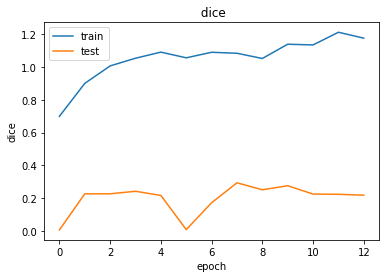

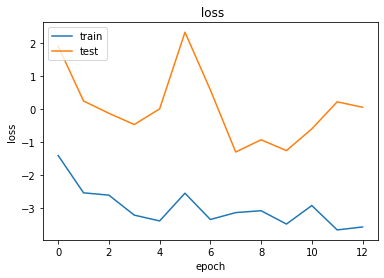

In [ ]:
plt_data_from_history(history, "", 'dice')
plt_data_from_history(history, "", 'loss')


----- Image: 0 -----
Input:


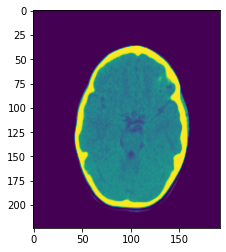

True output:


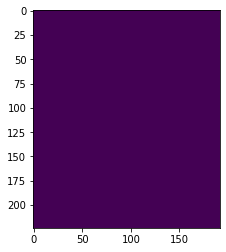

Our output:


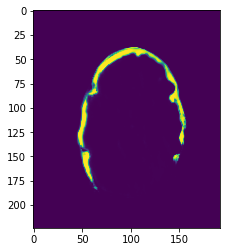


----- Image: 1 -----
Input:


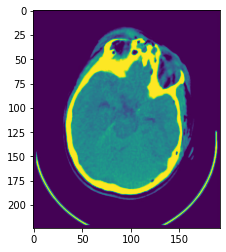

True output:


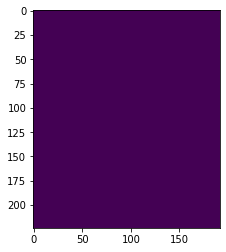

Our output:


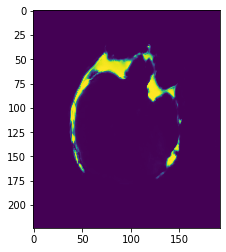


----- Image: 2 -----
Input:


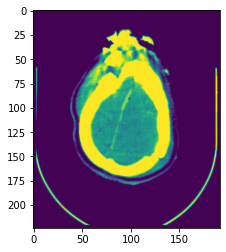

True output:


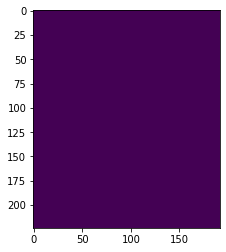

Our output:


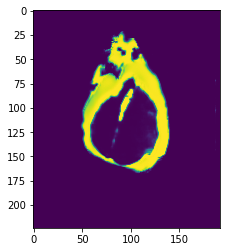


----- Image: 3 -----
Input:


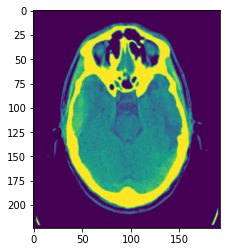

True output:


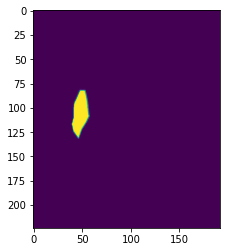

Our output:


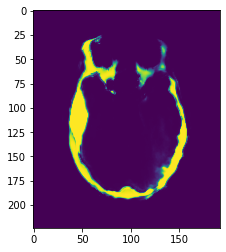


----- Image: 4 -----
Input:


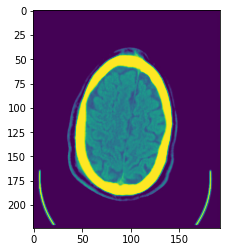

True output:


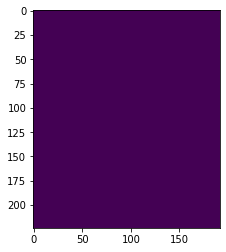

Our output:


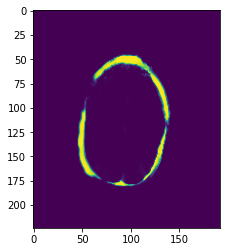


----- Image: 5 -----
Input:


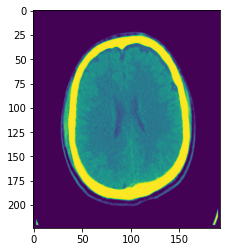

True output:


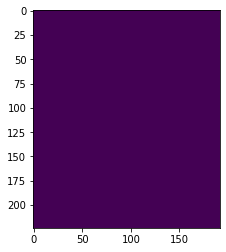

Our output:


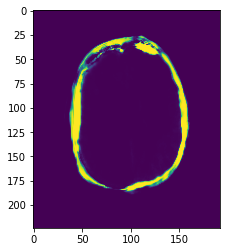


----- Image: 6 -----
Input:


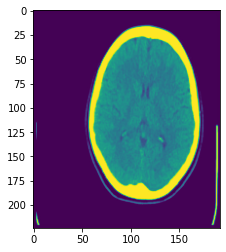

True output:


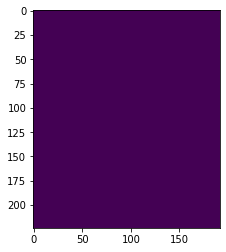

Our output:


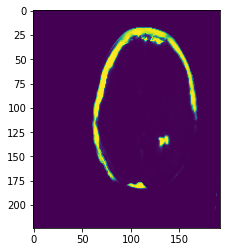


----- Image: 7 -----
Input:


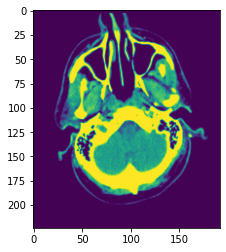

True output:


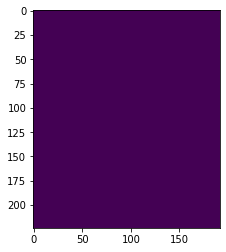

Our output:


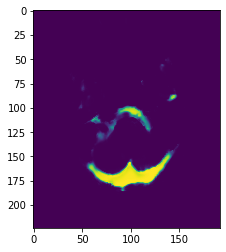


----- Image: 8 -----
Input:


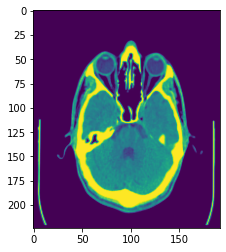

True output:


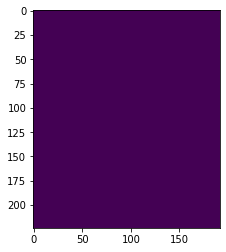

Our output:


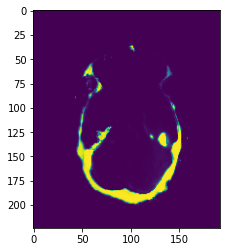


----- Image: 9 -----
Input:


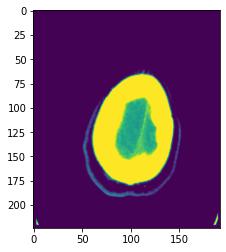

True output:


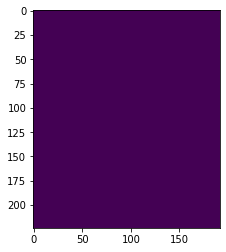

Our output:


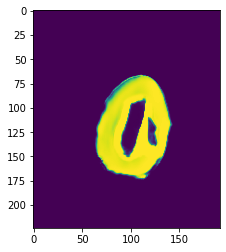

In [ ]:
N = 10
pos = [random.randint(0, len(x_test)-1) for _ in range(N)]

in_m = np.array([x_test[i] for i in pos])
true_out_m = np.array([y_test[i] for i in pos])

in_m = in_m.reshape((len(in_m), 224, 192, 1))

out_m = model.predict(in_m)

for j in range(len(out_m)):
  print("\n----- Image: %d -----" %j)
  print("Input:")
  plt.imshow( in_m[j].reshape((224, 192)) )
  plt.show()
  print("True output:")
  plt.imshow( true_out_m[j].reshape((224, 192)) )
  plt.show()
  print("Our output:")
  plt.imshow( out_m[j].reshape((224, 192)) )
  plt.show()